In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [4]:
tickers = ["GE", "PFE","SBUX"]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')

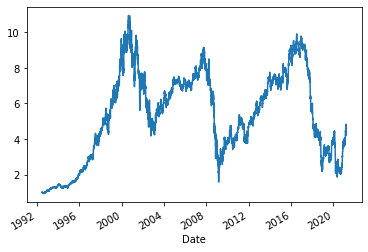

In [64]:
(1+stocks["GE"]).cumprod().plot()


In [66]:

def get_weights(data, mean, std, covar):
    

    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = data.count()
    r0 = mean[1] #r-naught for calculation 
    covar_inverse = np.linalg.inv(covar.values)
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((len(data.columns), 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

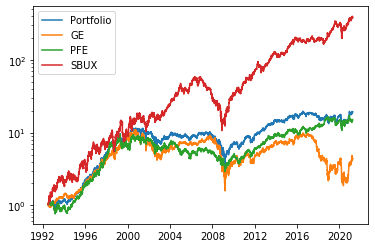

In [84]:
mean = stocks.mean(axis=0).values.reshape((len(tickers), 1))
std = stocks.std(axis=0)
covar = stocks.cov()
weight_vector = get_weights(stocks, mean, std, covar)
portfolio_ps = stocks.dot(weight_vector)
plt.figure()
plt.plot((1+portfolio_ps).cumprod(), label="Portfolio")
for ticker in stocks:
    plt.plot((1+stocks[ticker]).cumprod(), label=ticker)
plt.yscale("log")
plt.legend()

In [85]:
weight_vector

array([[0.36181855],
       [0.56770037],
       [0.07048109]])

In [70]:
stocks.dot(weight_vector).mean()
stocks.dot(weight_vector).std()

NameError: name 'weight_vector' is not defined

In [ ]:
stocks["PFE"].mean()
stocks["PFE"].std()

In [ ]:
[stock_samples] = np.random.normal((i for i in mean), std, n)
histograms = [i.hist(bins=100, density=True, axis = 1) for i in stocks]
std_histograms = plt.hist(samples, bins=100, density=True, alpha = 0.5)
plt.yscale('log')

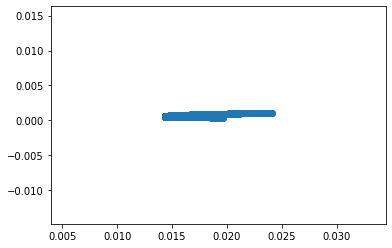

In [7]:
def get_random_weights():
    random = np.random.random(2)     
    return np.diff(np.concatenate(([0], sorted(random),[1])))

random_weights = [get_random_weights() for i in range(10000)]
means = [stocks.dot(weight).mean() for weight in random_weights]
stds = [stocks.dot(weight).std() for weight in random_weights]
plt.scatter(stds, means)

In [8]:
stocks.mean()

GE      0.000398
PFE     0.000516
SBUX    0.001117
dtype: float64

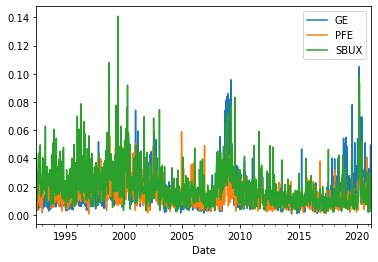

In [9]:
stocks.resample("7D").std().plot()

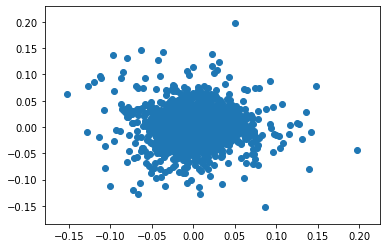

In [10]:
plt.scatter(stocks["GE"].shift(1).dropna(), stocks["GE"].iloc[1:])

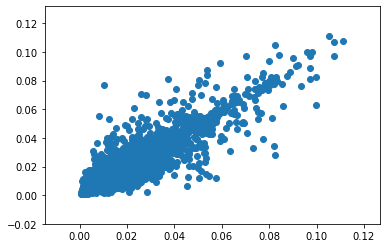

In [11]:
plt.scatter(stocks["GE"].rolling("7d").std().shift(1).dropna(), stocks["GE"].rolling("7d").std().dropna().iloc[1:])

In [54]:
X = stocks["GE"].resample("7d").std().shift(1).dropna().iloc[:-1]
Y = stocks["GE"].resample("7d").std().dropna().iloc[1:]
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, train_size = 0.7)
X

Date
1992-07-06    0.015704
1992-07-13    0.013957
1992-07-20    0.008664
1992-07-27    0.012370
1992-08-03    0.010844
                ...   
2021-02-22    0.024781
2021-03-01    0.031906
2021-03-08    0.023048
2021-03-15    0.049579
2021-03-22    0.036566
Name: GE, Length: 1498, dtype: float64

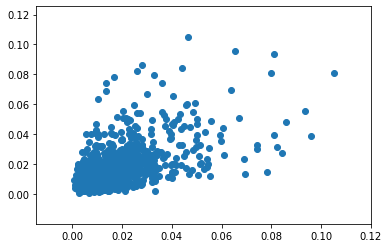

In [49]:
plt.scatter(X,Y)

In [55]:
xgb_instance = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 1000, learning_rate = 0.08, gamma=0, subsample=0.75, colsample_bytree=1)

In [53]:
train_X.values


array([0.0132557 , 0.02999207, 0.01147014, ..., 0.01728734, 0.02977001,
       0.00249534])

In [57]:
xgb_instance.fit(train_X.values.reshape((len(train_X), 1)), train_Y.values)

[18:46:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [58]:
y_pred = xgb_instance.predict(test_X.values.reshape((len(test_X), 1)))

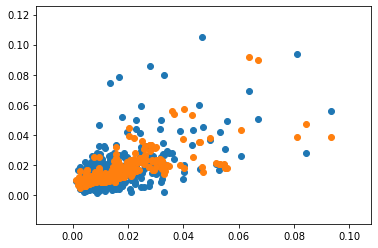

In [59]:
plt.scatter(test_X, test_Y)
plt.scatter(test_X, y_pred)